# Transformers for Time Series Forecasting

In this lab, you will implement and experiment with transformer-based models for time series
forecasting. You will learn about:
- RevIN (Reversible Instance Normalization) for handling distribution shifts
- PatchTST: a patch-based transformer architecture for time series
- Training with SAM (Sharpness-Aware Minimization) loss

In [1]:
import numpy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Part 1: Unified Data Loaders

In this section, you will create data loaders for ETTh1, reusing code from previous lab sessions.

**Question 1.** Create a unified data loader function. It should:
- Support the natively multivariate `ETTh1Dataset` from Lab 2 
  (multivariate inputs, univariate outputs)
- Do not scale input features (you will use RevIn layers in your models for that)
- Return training and validation data loaders

In [2]:

# Reuse ETTh1Dataset from Lab 2 without scaling (we will use RevIn normalization layers)
def load_etth1(csv_path, use_time_feat=True):
    def to_str(str_or_bytes):
        if isinstance(str_or_bytes, str):
            return str_or_bytes
        else:
            return str_or_bytes.decode()
    
    d_conv = {
        0: (lambda x: float(to_str(x).split(" ")[1].split(":")[0]))
    }
    raw = numpy.loadtxt(csv_path, delimiter=",", skiprows=1, converters=d_conv)
    features = raw.astype(numpy.float32)
    if use_time_feat:
        features[:, 0] /= 23.
    else:
        features = features[:, 1:]
    return features


class ETTh1Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, window, horizon, 
                 use_time_feat=True, 
                 start=0, end=None):
        feats = load_etth1(csv_path, use_time_feat=use_time_feat)
        feats = feats[start:]
        if end is not None:
            feats = feats[:end]
        self.feats = feats
        self.window = window
        self.horizon = horizon
        self.max_start = len(feats) - window - horizon + 1
        if self.max_start < 1:
            raise ValueError("Window + horizon exceeds series length")

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx):
        past = self.feats[idx : idx + self.window]
        future = self.feats[idx + self.window : idx + self.window + self.horizon, -1:]
        return torch.from_numpy(past), torch.from_numpy(future)


def build_etth1_dataloaders(csv_path, window=96, horizon=24, batch_size=64, split=0.8):
    dataset = ETTh1Dataset(csv_path, window, horizon)
    n = len(dataset)
    n_train = int(split * n)
    
    train_ds = ETTh1Dataset(csv_path, window, horizon, end=n_train)
    valid_ds = ETTh1Dataset(csv_path, window, horizon, start=n_train)
    
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    # Get input dimension
    sample_past, _ = train_ds[0]
    input_dim = sample_past.shape[-1]
    
    return train_dl, valid_dl, input_dim

window = 96
horizon = 24
train_dl, valid_dl, input_dim = build_etth1_dataloaders(
    "data/ETTh1.csv", window=window, horizon=horizon
)

## Part 2: RevIN (Reversible Instance Normalization)

RevIN is a normalization technique that helps transformers handle distribution shifts
in time series data. It normalizes each instance (time series) independently and
can be reversed after processing.

**Question 2.** Implement the RevIN module:
- Normalize input by subtracting mean and dividing by standard deviation (per instance)
- Store the statistics to reverse the normalization after processing
- Define learnable scaling parameters $\gamma$ and $\beta$
- Support both forward (normalize) and reverse (denormalize) operations
- Allow specification of a target channel for the multivariate-to-univariate 
  forecasting use case.

In [3]:
class RevIN(nn.Module):
    """Reversible Instance Normalization for time series."""
    
    def __init__(self, num_features: int, target_channel=None, eps=1e-5, affine=True):
        """
        Args:
            num_features: number of features/channels
            target_channel: id of the channel to be forecast (in multivariate-to-univariate settings)
            eps: small constant for numerical stability
            affine: whether to use learnable affine parameters
        """
        super().__init__()
        self.num_features = num_features
        self.target_channel = target_channel
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()
    
    def forward(self, x, mode: str):
        """
        Args:
            x: input tensor of shape (batch, seq_len, num_features)
            mode: 'norm' for normalization, 'denorm' for denormalization
        """
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise ValueError("mode must be 'norm' or 'denorm'")
        return x
    
    def _init_params(self):
        # Learnable affine parameters
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
    
    def _get_statistics(self, x):
        # Compute mean and std along the sequence dimension (dim=1)
        # x: (batch, seq_len, num_features)
        self.mean = x.mean(dim=1, keepdim=True)  # (batch, 1, num_features)
        self.std = x.std(dim=1, keepdim=True) + self.eps  # (batch, 1, num_features)
    
    def _normalize(self, x):
        x = (x - self.mean) / self.std
        if self.affine:
            x = x * self.gamma + self.beta
        return x
    
    def _denormalize(self, x):
        if self.target_channel is not None:
            beta = self.beta[self.target_channel]
            gamma = self.gamma[self.target_channel]
            mean = self.mean[:, :, self.target_channel].unsqueeze(-1)
            std = self.std[:, :, self.target_channel].unsqueeze(-1)
        else:
            beta = self.beta
            gamma = self.gamma
            mean = self.mean
            std = self.std
        if self.affine:
            x = (x - beta) / gamma
        x = x * std + mean
        return x

**Question 3.** Visualize the impact of this RevIN normalization/denormalization on a small set of time series from your data loader. Focus your visualizations on the target feature.

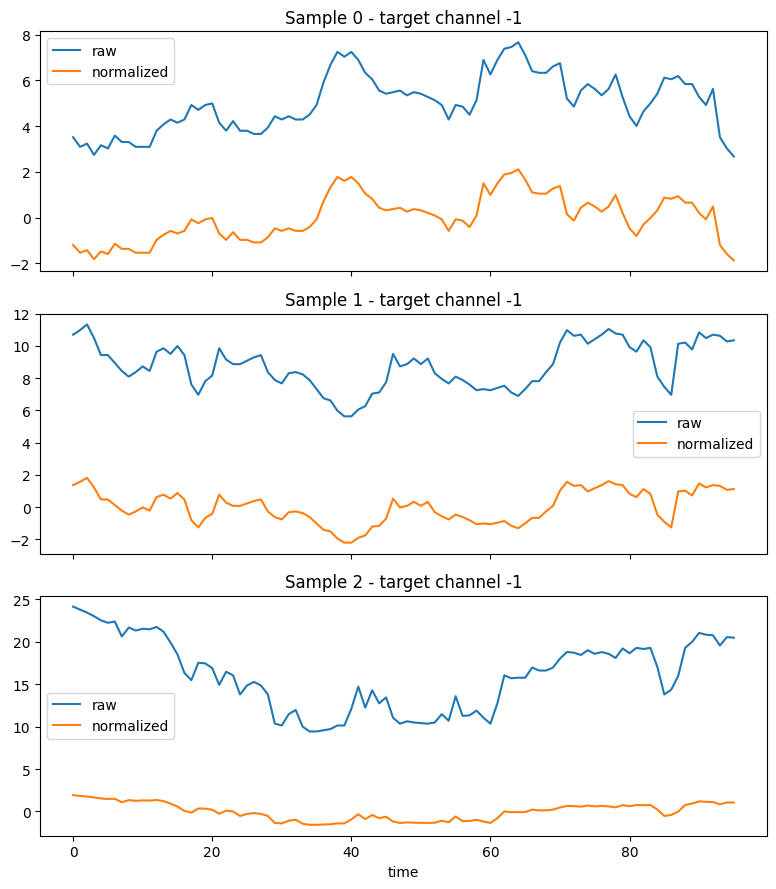

In [4]:
@torch.no_grad()
def visualize_revin_timeseries(dataloader, target_channel: int = -1, num_examples: int = 3):
    """Plot raw, normalized and denormalized series for a few samples."""
    past, _ = next(iter(dataloader))
    num_features = past.shape[-1]
    revin = RevIN(num_features=num_features, target_channel=target_channel)
    
    norm = revin(past, mode="norm")
    norm_target = norm[:, :, target_channel]
    
    num_examples = min(num_examples, past.size(0))
    t = numpy.arange(past.size(1))
    fig, axes = plt.subplots(num_examples, 1, figsize=(8, 3 * num_examples), sharex=True)
    axes = axes if num_examples > 1 else [axes]
    for i in range(num_examples):
        axes[i].plot(t, past[i, :, target_channel].numpy(), label="raw", color="tab:blue")
        axes[i].plot(t, norm_target[i, :].numpy(), label="normalized", color="tab:orange")
        axes[i].set_title(f"Sample {i} - target channel {target_channel}")
        axes[i].legend()
    axes[-1].set_xlabel("time")
    fig.tight_layout()
    plt.show()

# Example (will display figures):
visualize_revin_timeseries(train_dl, target_channel=-1, num_examples=3)

**Question 4.** Now visualize the impact of this RevIN normalization/denormalization at the distribution scale. Once again, focus on the target feature and plot training and validation empirical distributions before/after normalization.

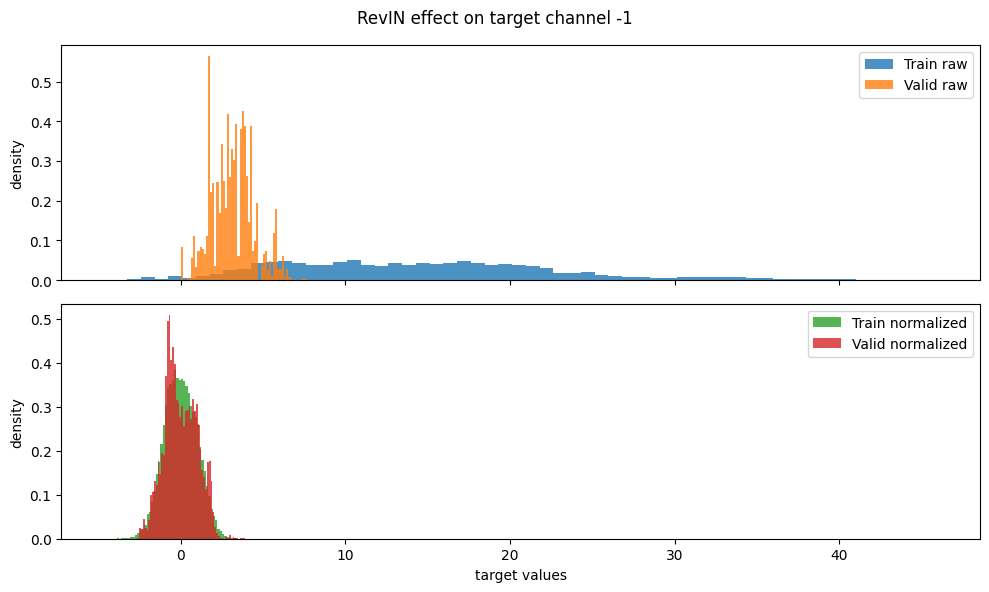

In [5]:
@torch.no_grad()
def visualize_revin_distributions(train_dl, valid_dl, target_channel: int = -1, max_batches: int = 10, bins: int = 60):
    """Compare target-feature distributions before/after RevIN for train and validation."""
    def collect_batches(dataloader):
        xs = []
        count = 0
        for past, _ in dataloader:
            xs.append(past[:, :, target_channel].reshape(-1))
            count += 1
            if count >= max_batches:
                break
        return torch.cat(xs, dim=0)
    
    # Gather raw values
    train_raw = collect_batches(train_dl)
    valid_raw = collect_batches(valid_dl)
    
    revin = RevIN(num_features=train_dl.dataset.feats.shape[1], target_channel=target_channel)
    def collect_normed(dataloader):
        normed = []
        for past, _ in dataloader:
            norm = revin(past, mode="norm")
            normed.append(norm[:, :, target_channel].reshape(-1))
            if len(normed) >= max_batches:
                break
        return torch.cat(normed, dim=0)
    
    train_norm = collect_normed(train_dl)
    valid_norm = collect_normed(valid_dl)
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    axes[0].hist(train_raw.numpy(), bins=bins, density=True, alpha=0.8, color="tab:blue", label="Train raw")
    axes[0].hist(valid_raw.numpy(), bins=bins, density=True, alpha=0.8, color="tab:orange", label="Valid raw")
    axes[1].hist(train_norm.numpy(), bins=bins, density=True, alpha=0.8, color="tab:green", label="Train normalized")
    axes[1].hist(valid_norm.numpy(), bins=bins, density=True, alpha=0.8, color="tab:red", label="Valid normalized")
    for ax in axes[-1:]:
        ax.set_xlabel("target values")
    for ax in axes:
        ax.set_ylabel("density")
    fig.suptitle(f"RevIN effect on target channel {target_channel}", fontsize=12)
    fig.tight_layout()
    axes[0].legend()
    axes[1].legend()
    plt.show()

# Example (will display figures):
visualize_revin_distributions(train_dl, valid_dl, target_channel=-1, max_batches=5)

## Part 3: PatchTST

PatchTST (Patch-based Time Series Transformer) divides the input time series into
patches and processes them with a transformer. This approach is more efficient than
processing individual time steps.

**Question 5.** Implement a minimal PatchTST model for univariate forecasting  
*At this stage, keep the simple channel-mixing implementation (no channel independence yet).*
- Divide the input sequence into patches of a given length
- Project patches to a model dimension
- Add learnable positional encodings
- Apply a standard transformer encoder 
  (use `nn.TransformerEncoder` and `nn.TransformerEncoderLayer` classes)
- Mean-pool patch representations and predict the forecast horizon using a linear head

In [6]:
class PatchTST(nn.Module):
    """Patch-based Time Series Transformer for univariate forecasting."""
    
    def __init__(self, 
                 seq_len: int,
                 pred_len: int,
                 num_features: int,
                 patch_len: int,
                 stride: int,
                 d_model: int = 128,
                 n_heads: int = 8,
                 n_layers: int = 3,
                 d_ff: int = 256,
                 dropout: float = 0.1,
                 revin: bool = True):
        """
        Args:
            seq_len: input sequence length (window size)
            pred_len: prediction horizon length
            num_features: number of input channels
            patch_len: length of each patch
            stride: stride for patch creation
            d_model: model dimension
            n_heads: number of attention heads
            n_layers: number of transformer layers
            d_ff: feedforward dimension
            dropout: dropout rate
            revin: whether to use RevIN
        """
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.revin = revin
        
        # Calculate number of patches
        self.num_patches = (seq_len - patch_len) // stride + 1
        
        # RevIN
        if revin:
            self.revin_layer = RevIN(num_features=num_features, target_channel=-1, affine=True)
        
        # Patch embedding: project patches to d_model
        self.patch_embedding = nn.Linear(patch_len * num_features, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, self.num_patches, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Prediction head
        self.head = nn.Linear(d_model, pred_len)
    
    def create_patches(self, x):
        """
        Create patches from input sequence.
        Args:
            x: (batch, seq_len, 1) for univariate
        Returns:
            patches: (batch, num_patches, patch_len)
        """
        B = x.shape[0]
        patches = []
        for i in range(0, self.seq_len - self.patch_len + 1, self.stride):
            patch = x[:, i:i+self.patch_len, :]  # (batch, patch_len, c)
            patches.append(patch.view(B, -1))  # (batch, patch_len * c)
        patches = torch.stack(patches, dim=1)  # (batch, num_patches, patch_len * c)
        return patches
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, 1) for univariate
        Returns:
            pred: (batch, pred_len)
        """
        # RevIN normalization
        if self.revin:
            x = self.revin_layer(x, mode='norm')
        
        # Create patches
        patches = self.create_patches(x)  # (batch, num_patches, patch_len)
        
        # Embed patches
        patch_emb = self.patch_embedding(patches)  # (batch, num_patches, d_model)
        
        # Add positional encoding
        patch_emb = patch_emb + self.pos_encoding
        
        # Transformer encoding
        encoded = self.transformer(patch_emb)  # (batch, num_patches, d_model)
        
        # Aggregate: use mean pooling over patches
        aggregated = encoded.mean(dim=1)  # (batch, d_model)
        
        # Prediction
        pred = self.head(aggregated).unsqueeze(-1)  # (batch, pred_len, 1)
        
        # RevIN denormalization
        if self.revin:
            pred = self.revin_layer(pred, mode='denorm')
        
        return pred

**Question 6.** Compare performance of the following models on the ETTh1 dataset:
- PatchTST without RevIN and using patches of size 1
- PatchTST with RevIN and using patches of size 1
- PatchTST without RevIN and using patches of size 16
- PatchTST with RevIN and using patches of size 16

In [7]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for past, future in dataloader:
        optimizer.zero_grad()
        pred = model(past)  # pred: (batch, horizon, 1)
        loss = criterion(pred, future)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * past.size(0)
    return total_loss / len(dataloader.dataset)


@torch.no_grad()
def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    for past, future in dataloader:
        pred = model(past)
        loss = criterion(pred, future)
        total_loss += loss.item() * past.size(0)
    return total_loss / len(dataloader.dataset)


def train_and_valid_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs):
    logs = {"train_loss": [], "valid_loss": []}
    print(model.__class__.__name__)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_dl, optimizer, criterion)
        logs["train_loss"].append(train_loss)
        valid_loss = eval_epoch(model, valid_dl, criterion)
        logs["valid_loss"].append(valid_loss)
        print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    return logs

# Train PatchTST
for use_revin in [False, True]:
    for patch_len in [1, 16]:
        if patch_len > 1:
            stride = patch_len // 2
        else:
            stride = 1
        print(f"revin={use_revin}, patch_len={patch_len}")
        patch_tst = PatchTST(
            seq_len=window,
            pred_len=horizon,
            num_features=input_dim,
            patch_len=patch_len,
            stride=stride,
            d_model=64,
            n_heads=4,
            n_layers=2,
            d_ff=128,
            revin=use_revin
        )

        optimizer = torch.optim.Adam(patch_tst.parameters(), lr=1e-4)
        criterion = nn.MSELoss()
        logs_patchtst = train_and_valid_loop(patch_tst, train_dl, valid_dl, optimizer, criterion, n_epochs=20)

revin=False, patch_len=1
PatchTST
Epoch 00 | train=256.0491 | valid=41.6317
Epoch 01 | train=214.3646 | valid=26.1137
Epoch 02 | train=176.9965 | valid=15.7081
Epoch 03 | train=143.8294 | valid=9.3198
Epoch 04 | train=116.1532 | valid=5.7748
Epoch 05 | train=93.4649 | valid=4.1520
Epoch 06 | train=75.2736 | valid=4.1540
Epoch 07 | train=60.9598 | valid=3.8987
Epoch 08 | train=49.8637 | valid=3.9990
Epoch 09 | train=41.4318 | valid=3.8750
Epoch 10 | train=34.9021 | valid=3.7433
Epoch 11 | train=29.7516 | valid=3.4542
Epoch 12 | train=25.5254 | valid=3.6157
Epoch 13 | train=22.0488 | valid=3.6885
Epoch 14 | train=19.0740 | valid=3.5819
Epoch 15 | train=16.5911 | valid=3.4483
Epoch 16 | train=14.5250 | valid=3.5605
Epoch 17 | train=12.7930 | valid=3.6382
Epoch 18 | train=11.2882 | valid=3.6301
Epoch 19 | train=10.0785 | valid=3.6282
revin=False, patch_len=16
PatchTST
Epoch 00 | train=261.3245 | valid=44.1110
Epoch 01 | train=219.9557 | valid=28.3012
Epoch 02 | train=182.7736 | valid=17.46

KeyboardInterrupt: 

**Question 6bis.** Channel independence in PatchTST  
One hallmark of PatchTST is channel-independent patch processing (depthwise patch embedding), which is not implemented above.  
- Implement a channel-independent variant (one embedding per channel, no cross-channel mixing before the transformer). The typical implementation trick for this is to reorganize tensor dimensions such that independent channels can be processed as if they were independent time series, such that the batch dimension becomes B*C.
- Compare its performance with the mixed-channel version from Question 6 on ETTh1.  
- Discuss when channel independence helps or hurts.

In [ ]:
class PatchTST_ChannelIndependent(nn.Module):
    """
    Channel-independent PatchTST.
    Each channel is processed independently with shared weights.
    """

    def __init__(self,
                 seq_len: int,
                 pred_len: int,
                 num_features: int,
                 patch_len: int,
                 stride: int,
                 d_model: int = 128,
                 n_heads: int = 8,
                 n_layers: int = 3,
                 d_ff: int = 256,
                 dropout: float = 0.1,
                 revin: bool = True):
        super().__init__()

        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features
        self.patch_len = patch_len
        self.stride = stride
        self.revin = revin

        self.num_patches = (seq_len - patch_len) // stride + 1

        if revin:
            self.revin_layer = RevIN(num_features=num_features, affine=True)

        # Patch embedding is now PER-CHANNEL
        self.patch_embedding = nn.Linear(patch_len, d_model)

        self.pos_encoding = nn.Parameter(
            torch.randn(1, self.num_patches, d_model)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers
        )

        # One head per channel (shared weights)
        self.head = nn.Linear(d_model, pred_len)

    def create_patches(self, x):
        """
        x: (B, T, 1)
        returns: (B, num_patches, patch_len)
        """
        B = x.shape[0]
        patches = []
        for i in range(0, self.seq_len - self.patch_len + 1, self.stride):
            patch = x[:, i:i+self.patch_len, 0]
            patches.append(patch)
        patches = torch.stack(patches, dim=1)
        return patches

    def forward(self, x):
        """
        x: (B, T, C)
        returns: (B, pred_len, C)
        """
        B, T, C = x.shape

        if self.revin:
            x = self.revin_layer(x, mode="norm")

        # Treat channels independently
        x = x.permute(0, 2, 1).reshape(B * C, T, 1)

        patches = self.create_patches(x)
        patch_emb = self.patch_embedding(patches)
        patch_emb = patch_emb + self.pos_encoding

        encoded = self.transformer(patch_emb)
        aggregated = encoded.mean(dim=1)

        pred = self.head(aggregated)  # (B*C, pred_len)
        pred = pred.view(B, C, self.pred_len).permute(0, 2, 1)
        pred = pred[:, :, -1:]  # target feature is -1

        if self.revin:
            pred = self.revin_layer(pred, mode="denorm")

        return pred

patch_tst = PatchTST_ChannelIndependent(
    seq_len=window,
    pred_len=horizon,
    num_features=input_dim,
    patch_len=patch_len,
    stride=stride,
    d_model=64,
    n_heads=4,
    n_layers=2,
    d_ff=128,
    revin=use_revin
)

optimizer = torch.optim.Adam(patch_tst.parameters(), lr=1e-4)
criterion = nn.MSELoss()
logs_patchtst = train_and_valid_loop(patch_tst, train_dl, valid_dl, optimizer, criterion, n_epochs=20)

# Part 4: Training with SAM (Sharpness-Aware Minimization)

Sharpness-Aware Minimization (SAM) improves generalization by encouraging
solutions that lie in flat regions of the loss landscape.

In this part:
- You are GIVEN an implementation of the SAM optimizer
- You must implement a SAM training step
- You must adapt the training loop accordingly

Important notes:
- The loss function is NOT modified
- The validation loop remains unchanged
- Only the training step differs from standard optimization

In [ ]:
class SAM(torch.optim.Optimizer):
    """Sharpness-Aware Minimization optimizer wrapper."""
    
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        
        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
    
    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w
        
        if zero_grad:
            self.zero_grad()
    
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"
        
        self.base_optimizer.step()  # do the actual "sharpness-aware" update
        
        if zero_grad:
            self.zero_grad()
    
    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2).to(shared_device)
                for group in self.param_groups for p in group["params"]
                if p.grad is not None
            ]),
            p=2
        )
        return norm
    
    def step(self, closure=None):
        raise NotImplementedError("SAM doesn't work like the other optimizers, you should first call `first_step` and then `second_step`")

**Question 7.** Implement a SAM training step
The SAM optimizer exposes two methods:
  - optimizer.first_step()
  - optimizer.second_step()

Implement a function `sam_step` that:
  1. Computes the loss and gradients at the current parameters
  2. Calls `first_step()` to move to a nearby point of higher loss
  3. Recomputes the loss and gradients at the perturbed parameters
  4. Calls `second_step()` to update the model

The function should return the final loss value.

In [ ]:
def sam_step(model, optimizer, loss_fn, past, future):
    # First forward-backward pass (compute gradient at w)
    pred = model(past)
    loss = loss_fn(pred, future)
    loss.backward()

    # Move to w + epsilon (ascent step)
    optimizer.first_step(zero_grad=True)

    # Second forward-backward pass (compute gradient at w + epsilon)
    pred = model(past)
    loss_sam = loss_fn(pred, future)
    loss_sam.backward()

    # Update parameters using sharpness-aware gradient
    optimizer.second_step(zero_grad=True)

    return loss_sam.item()

**Question 8.** Implement a training epoch using SAM

Using the `sam_step` function, implement a training epoch.
The structure should be similar to the standard training loop.

In [ ]:
def train_epoch_sam(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for past, future in dataloader:
        loss = sam_step(model, optimizer, criterion, past, future)
        total_loss += loss * past.size(0)

    return total_loss / len(dataloader.dataset)

**Question 9.** Full training loop with SAM

Complete the training-and-validation loop using the SAM-based training epoch.
The validation loop remains unchanged.

In [ ]:
def train_and_valid_loop_sam(model, train_dl, valid_dl, optimizer, criterion, n_epochs):
    logs = {"train_loss": [], "valid_loss": []}
    print(f"{model.__class__.__name__} (SAM)")

    for epoch in range(n_epochs):
        train_loss = train_epoch_sam(model, train_dl, optimizer, criterion)
        logs["train_loss"].append(train_loss)

        valid_loss = eval_epoch(model, valid_dl, criterion)
        logs["valid_loss"].append(valid_loss)

        print(
            f"Epoch {epoch:02d} | "
            f"train={train_loss:.4f} | "
            f"valid={valid_loss:.4f}"
        )

    return logs

**Question 8.** Compare the performance of:
- PatchTST (Adam)
- PatchTST (SAM)

Visualize the training curves and some example forecasts.

In [ ]:
# Train with SAM
patch_tst_sam = PatchTST_ChannelIndependent(
    seq_len=window,
    pred_len=horizon,
    patch_len=patch_len,
    stride=stride,
    num_features=input_dim,
    d_model=64,
    n_heads=4,
    n_layers=2,
    d_ff=128,
    revin=use_revin
)

base_optimizer = torch.optim.Adam
sam_optimizer = SAM(patch_tst_sam.parameters(), base_optimizer, lr=1e-3, rho=0.05)
criterion_sam = nn.MSELoss()
logs_patchtst_sam = train_and_valid_loop_sam(patch_tst_sam, train_dl, valid_dl, 
                                              sam_optimizer, criterion_sam, n_epochs=20)
# Compare training curves
plt.figure(figsize=(10, 6))
plt.plot(logs_patchtst["valid_loss"], label="PatchTST (Adam)")
plt.plot(logs_patchtst_sam["valid_loss"], label="PatchTST (SAM)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Comparison of PatchTST Variants")
plt.show()

# Visualize forecasts
def viz_forecast_models(models_dict, dataloader, ts_id=0):
    past, future = next(iter(dataloader))
    plt.figure(figsize=(12, 6))
    
    # Plot past
    if past.dim() == 3 and past.shape[2] > 1:
        plt.plot(range(past.shape[1]), past[ts_id, :, -1].numpy(), 
                label="Past window (target channel)", color='blue')
    else:
        plt.plot(range(past.shape[1]), past[ts_id, :, 0].numpy(), 
                label="Past window", color='blue')
    
    # Plot ground truth
    if future.dim() == 2:
        future_plot = future[ts_id].numpy()
    else:
        future_plot = future[ts_id, :, 0].numpy()
    plt.plot(range(past.shape[1], past.shape[1] + len(future_plot)), 
            future_plot, label="Ground truth", color='green', linewidth=2)
    
    # Plot predictions
    for label, model in models_dict.items():
        with torch.no_grad():
            pred = model(past[ts_id:ts_id+1])
            if pred.dim() == 2:
                pred_plot = pred[0].numpy()
            else:
                pred_plot = pred[0, :, 0].numpy()
        plt.plot(range(past.shape[1], past.shape[1] + len(pred_plot)), 
                pred_plot, label=label, linestyle='--')
    
    plt.axvline(x=past.shape[1]-0.5, color='gray', linestyle=':', alpha=0.5)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Forecast Comparison")
    plt.show()

models_to_compare = {
    "PatchTST (Adam)": patch_tst,
    "PatchTST (SAM)": patch_tst_sam
}

viz_forecast_models(models_to_compare, valid_dl)